/tmp/ipykernel_545813/1728802156.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


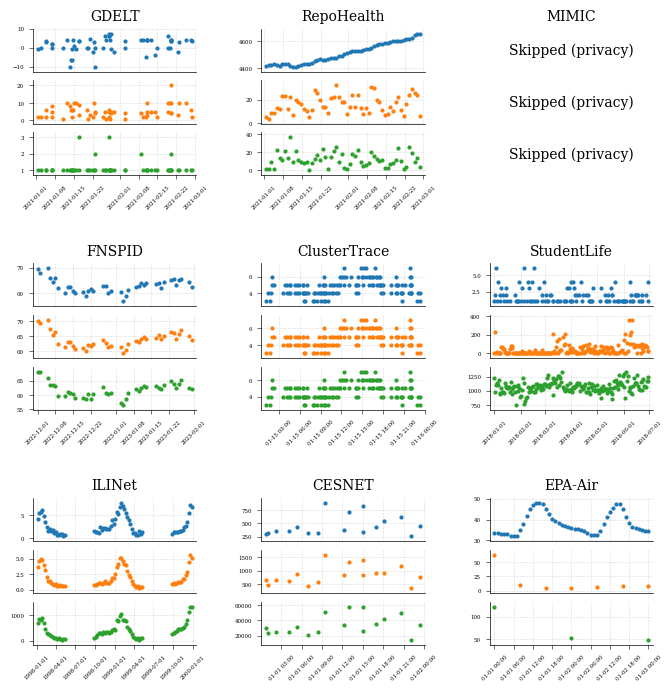

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from pathlib import Path

# --- Global style settings ---
plt.rcParams.update(
    {
        "font.family": "serif",  # LaTeX-style serif font
        "font.size": 10,
        "axes.labelsize": 5,
        "axes.titlesize": 10,
        "xtick.labelsize": 4,
        "ytick.labelsize": 4,
        "axes.linewidth": 0.5,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "grid.color": "0.85",
        "grid.linestyle": "--",
        "grid.linewidth": 0.4,
    }
)


def plot_irregular_ts(
    dataset_name,
    proper_time_range=None,
    figsize=(8, 4),
    time_format="%m-%d %H:%M",
    margin_x_pct=0.03,
    margin_y_pct=0.15,
    relative_time=False,
    ax_list=None,
):
    # Read the dataset
    csv_path = next(Path("data", dataset_name, "processed").glob("*/time_series.csv"))
    df = pd.read_csv(csv_path, parse_dates=["date_time"], index_col="date_time")
    df = df.drop(columns="record_id").iloc[:, :3]  # Keep only first 3 features

    if proper_time_range:
        start, end = pd.to_datetime(proper_time_range)
        df = df.loc[start:end]

    if relative_time:
        base_time = df.index.min()
        df.index = (df.index - base_time).total_seconds() / 60  # in minutes

    n = df.shape[1]
    cmap = plt.get_cmap("tab10")

    # Set up axes
    if ax_list is None:
        fig, axes = plt.subplots(n, 1, sharex=True, figsize=figsize)
        if n == 1:
            axes = [axes]
    else:
        axes = ax_list
        fig = axes[0].figure

    fig.patch.set_facecolor("white")  # ensure white background

    # X-axis limits with margin
    x_min, x_max = df.index.min(), df.index.max()
    x_range = x_max - x_min
    x_pad = margin_x_pct * x_range
    x_limits = (x_min - x_pad, x_max + x_pad)

    for ax, (col, color) in zip(axes, zip(df.columns, cmap.colors)):
        series = df[col].dropna()
        # ax.plot(series.index, series.values, linestyle="-", linewidth=0.8, color=color)
        ax.plot(
            series.index,
            series.values,
            marker="o",
            linestyle="",
            color=color,
            markersize=2,
        )

        # Y-axis margin
        y_min, y_max = series.min(), series.max()
        y_pad = margin_y_pct * (y_max - y_min) if y_max != y_min else margin_y_pct
        ax.set_ylim(y_min - y_pad, y_max + y_pad)

        ax.set_xlim(*x_limits)

        # Clean aesthetics
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(True)

        # Hide x-axis ticks if not bottom
        if ax is not axes[-1]:
            ax.tick_params(labelbottom=False, bottom=False)

    # Final x-axis formatting
    if relative_time:
        axes[-1].set_xlabel("Time (minutes since start)")
    else:
        axes[-1].xaxis.set_major_formatter(mdates.DateFormatter(time_format))
        axes[-1].tick_params(axis="x", rotation=45)

    # Only show or layout if standalone
    if ax_list is None:
        plt.tight_layout()
        plt.show()

    return fig, axes
    


# Configuration for each dataset
dataset_configs = {
    "GDELT": {
        "proper_time_range": ("2021-01-01", "2021-02-28"),
        "relative_time": False,
        "time_format": "%Y-%m-%d",
    },
    "RepoHealth": {
        "proper_time_range": ("2021-01-01", "2021-02-28"),
        "relative_time": False,
        "time_format": "%Y-%m-%d",
    },
    "MIMIC": {
        "proper_time_range": ("2000-01-17", "2000-02-06"),
        "relative_time": True,
        "time_format": "%Y-%m-%d",
    },
    "FNSPID": {
        "proper_time_range": ("2022-12-01", "2023-01-31"),
        "relative_time": False,
        "time_format": "%Y-%m-%d",
    },
    "ClusterTrace": {
        "proper_time_range": ("2000-01-15", "2000-01-16"),
        "relative_time": False,
        "time_format": "%m-%d %H:%M",
    },
    "StudentLife": {
        "proper_time_range": ("2018-01-01", "2018-06-30"),
        "relative_time": False,
        "time_format": "%Y-%m-%d",
    },
    "ILINet": {
        "proper_time_range": ("1998-01-01", "2000-01-01"),
        "relative_time": False,
        "time_format": "%Y-%m-%d",
    },
    "CESNET": {
        "proper_time_range": ("2024-01-01", "2024-01-02"),
        "relative_time": False,
        "time_format": "%m-%d %H:%M",
    },
    "EPA-Air": {
        "proper_time_range": ("2024-01-01", "2024-01-03"),
        "relative_time": False,
        "time_format": "%m-%d %H:%M",
    },
}

# fig = plt.figure(figsize=(18, 16))
fig = plt.figure(figsize=(8, 8))
outer_grid = gridspec.GridSpec(3, 3, wspace=0.4, hspace=0.6)

for i, (dataset_name, config) in enumerate(dataset_configs.items()):

    inner_grid = gridspec.GridSpecFromSubplotSpec(
        3, 1, subplot_spec=outer_grid[i], hspace=0.2  # 3 subplots (one per column)
    )
    ax_list = [fig.add_subplot(inner_grid[j]) for j in range(3)]
    ax_list[0].set_title(dataset_name)

    if dataset_name == "MIMIC":
        for ax in ax_list:
            ax.text(0.5, 0.5, "Skipped (privacy)", ha="center", va="center")
            ax.axis("off")
        continue

    try:
        plot_irregular_ts(
            dataset_name,
            proper_time_range=config["proper_time_range"],
            relative_time=config["relative_time"],
            time_format=config["time_format"],
            ax_list=ax_list,
        )
    except Exception as e:
        for ax in ax_list:
            ax.text(0.5, 0.5, f"Error: {e}", ha="center", va="center", wrap=True)
            ax.axis("off")

plt.tight_layout()
plt.show()